In [2]:
import pandas as pd
import numpy as np

In [3]:
hin_df_folder = "/kaggle/input/modified-hate-speech-bengali-hindi/hindi-hate-speech/"
hin_df_dict = {}
hin_df_dict['train'] = pd.read_csv(hin_df_folder + "hindi-hate-speech_train.csv")
hin_df_dict['test'] = pd.read_csv(hin_df_folder + "hindi-hate-speech_test.csv")
hin_df_dict['valid'] = pd.read_csv(hin_df_folder + "hindi-hate-speech_valid.csv")

In [4]:
from datasets import Dataset, DatasetDict

In [5]:
hin_dataset_dict = DatasetDict()
for key in hin_df_dict.keys():
    hin_dataset_dict[key] = Dataset.from_pandas(hin_df_dict[key])

In [6]:
features = hin_dataset_dict['train'].column_names
features.remove('text')
num_features = len(features)
features, num_features

(['defamation', 'hate', 'non-hate', 'violence', 'vulgar'], 5)

In [7]:
id2label = {}
label2id = {}
for i, feature in enumerate(features):
    id2label[str(i)] = feature
    label2id[feature] = i

In [8]:
import tensorflow as tf
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification

2024-05-05 12:18:53.235453: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-05 12:18:53.235562: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-05 12:18:53.372278: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [9]:
model_name = "flax-community/roberta-hindi"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    problem_type="multi_label_classification",
    num_labels=num_features,
    id2label=id2label,
    label2id=label2id
)

tokenizer_config.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/692 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.55M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.86M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at flax-community/roberta-hindi and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
def tokenize_dataset(dataset):
    encoding = tokenizer(
        dataset['text'],
        padding="max_length",
        max_length=256,
        truncation=True
    )
    labels_batch = {k: dataset[k] for k in dataset.keys() if k in features}
    labels_matrix = np.zeros((len(dataset['text'],), len(features)))
    for idx, label in enumerate(features):
        labels_matrix[:, idx] = labels_batch[label]
    encoding['labels'] = labels_matrix.tolist()
    return encoding

encoded_dataset_dict_tokenized = hin_dataset_dict.map(
    tokenize_dataset,
    batched=True,
    remove_columns=['text'] + features
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/5728 [00:00<?, ? examples/s]

Map:   0%|          | 0/1653 [00:00<?, ? examples/s]

Map:   0%|          | 0/811 [00:00<?, ? examples/s]

In [11]:
encoded_dataset_dict_tokenized.set_format(
    type='torch'
)

In [12]:
encoded_dataset_dict_tokenized

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 5728
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1653
    })
    valid: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 811
    })
})

In [13]:
import sklearn.metrics as matrices
from transformers import EvalPrediction

In [14]:
# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    probs = tf.math.sigmoid(predictions)
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = matrices.f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = matrices.roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = matrices.accuracy_score(y_true, y_pred)
    hamming_loss = matrices.hamming_loss(y_true, y_pred)
    jaccard_score = matrices.jaccard_score(y_true, y_pred, average='micro')
    zero_one_loss = matrices.zero_one_loss(y_true, y_pred)
    # return as dictionary
    metrics = {
        'f1': f1_micro_average,
        'roc_auc': roc_auc,
        'accuracy': accuracy,
        'hamming_loss': hamming_loss,
        'jaccard_score': jaccard_score,
        'zero_one_loss': zero_one_loss
    }
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

In [15]:
from transformers import TrainingArguments, Trainer

In [40]:
args = TrainingArguments(
    output_dir='./results/',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    learning_rate=1e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=20,
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)

In [41]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset_dict_tokenized['train'],
    eval_dataset=encoded_dataset_dict_tokenized['valid'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [42]:
import os

In [43]:
files = os.listdir(args.output_dir)
if len(files) == 0:
    trainer.train()
else:
    trainer.train(resume_from_checkpoint=True)

Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy,Hamming Loss,Jaccard Score,Zero One Loss,Runtime,Samples Per Second,Steps Per Second
16,0.117300,0.172716,0.790393,0.858567,0.738594,0.071023,0.653430,0.261406,6.595500,122.962000,3.942000
17,0.107900,0.172746,0.786026,0.856047,0.734895,0.072503,0.647482,0.265105,6.572600,123.391000,3.956000
18,0.107900,0.175522,0.784370,0.856526,0.736128,0.073490,0.645238,0.263872,6.614400,122.612000,3.931000
19,0.107900,0.176245,0.787617,0.859674,0.737361,0.072750,0.649644,0.262639,6.585800,123.144000,3.948000
20,0.098800,0.176870,0.785612,0.858684,0.739827,0.073490,0.646919,0.260173,6.594800,122.976000,3.943000


In [44]:
trainer.evaluate()

{'eval_loss': 0.17133715748786926,
 'eval_f1': 0.7932797662527391,
 'eval_roc_auc': 0.8593175934555245,
 'eval_accuracy': 0.7435265104808878,
 'eval_hamming_loss': 0.06979038224414304,
 'eval_jaccard_score': 0.6573849878934624,
 'eval_zero_one_loss': 0.2564734895191122,
 'eval_runtime': 6.5412,
 'eval_samples_per_second': 123.983,
 'eval_steps_per_second': 3.975,
 'epoch': 20.0}

In [45]:
actual_labels = encoded_dataset_dict_tokenized['test']['labels']
pred_labels = trainer.predict(
    encoded_dataset_dict_tokenized['test']
)

In [46]:
probs = tf.math.sigmoid(pred_labels.predictions)
y_pred = np.zeros(probs.shape)
y_pred[np.where(probs >= 0.3)] = 1

In [47]:
print('Accuracy Score: ', matrices.accuracy_score(actual_labels, y_pred))
print('F1 Score: ', matrices.f1_score(actual_labels, y_pred, average='micro'))
print('ROC AUC: ', matrices.roc_auc_score(actual_labels, y_pred, average='micro'))
print('Hamming Loss: ', matrices.hamming_loss(actual_labels, y_pred))
print('Jaccard Score: ', matrices.jaccard_score(actual_labels, y_pred, average='micro'))
print('Zero-One Loss:', matrices.zero_one_loss(actual_labels, y_pred))

print('\nClassification Report :-\n',
      matrices.classification_report(
          actual_labels,
          y_pred,
          output_dict=False,
          target_names=features,
      )
     )

Accuracy Score:  0.7186932849364791
F1 Score:  0.7826653633105246
ROC AUC:  0.8741242348942562
Hamming Loss:  0.08070175438596491
Jaccard Score:  0.642933618843683
Zero-One Loss: 0.2813067150635209

Classification Report :-
               precision    recall  f1-score   support

  defamation       0.48      0.41      0.44       169
        hate       0.50      0.60      0.55       234
    non-hate       0.94      0.97      0.96       873
    violence       0.00      0.00      0.00         0
      vulgar       0.58      0.65      0.61       219

   micro avg       0.76      0.80      0.78      1495
   macro avg       0.50      0.53      0.51      1495
weighted avg       0.77      0.80      0.78      1495
 samples avg       0.65      0.68      0.66      1495



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

In [48]:
import matplotlib.pyplot as plt

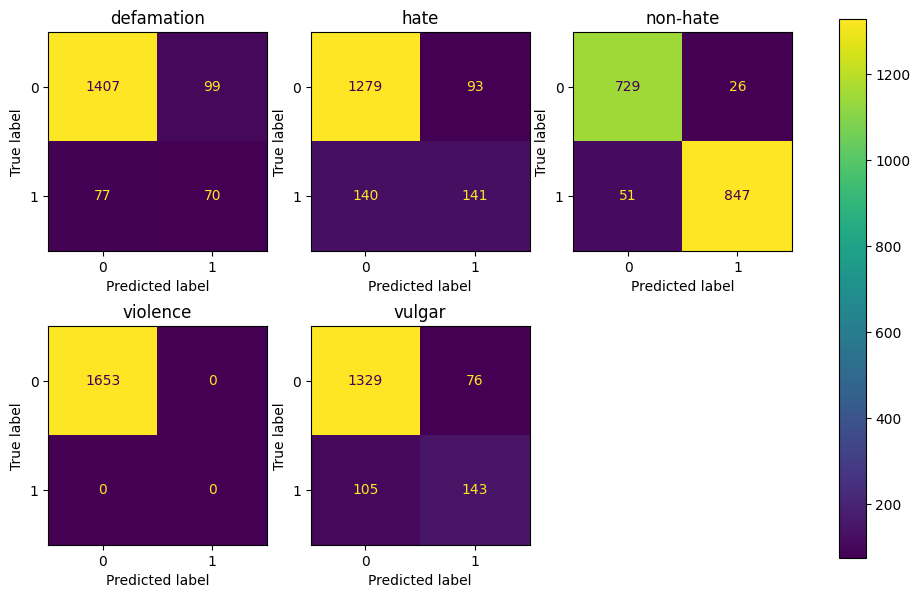

In [49]:
confusion_matrices =  matrices.multilabel_confusion_matrix(
    y_pred,
    actual_labels
)

fig, axis = plt.subplots(2, 3, figsize=(12, 7))
axis = axis.ravel()
for i in range(len(confusion_matrices)):
    disp = matrices.ConfusionMatrixDisplay(
        confusion_matrices[i],
    )
    disp.plot(ax=axis[i], values_format='.4g')
    disp.ax_.set_title(features[i])
    disp.im_.colorbar.remove()
fig.colorbar(disp.im_, ax=axis)
axis[5].remove()

In [50]:
trained_model_name = model_name.split('/')[1] + '-hate-speech-ben-hin-epochs-' + str(args.num_train_epochs)
trainer.save_model('./' + trained_model_name)

In [51]:
os.system("cd /kaggle/working/; zip -r "+trained_model_name+".zip ./"+trained_model_name)

  adding: roberta-hindi-hate-speech-ben-hin-epochs-20/ (stored 0%)
  adding: roberta-hindi-hate-speech-ben-hin-epochs-20/merges.txt (deflated 80%)
  adding: roberta-hindi-hate-speech-ben-hin-epochs-20/special_tokens_map.json (deflated 85%)
  adding: roberta-hindi-hate-speech-ben-hin-epochs-20/model.safetensors (deflated 7%)
  adding: roberta-hindi-hate-speech-ben-hin-epochs-20/tokenizer.json (deflated 83%)
  adding: roberta-hindi-hate-speech-ben-hin-epochs-20/config.json (deflated 52%)
  adding: roberta-hindi-hate-speech-ben-hin-epochs-20/vocab.json (deflated 77%)
  adding: roberta-hindi-hate-speech-ben-hin-epochs-20/training_args.bin (deflated 51%)
  adding: roberta-hindi-hate-speech-ben-hin-epochs-20/tokenizer_config.json (deflated 76%)


0

In [ ]:
os.system("rm -r ./" + trained_model_name)